# Phishing Email Detection with MLP: Overview & Workflow

This notebook provides a step-by-step guide to the complete hands-on process of phishing email detection using an MLP (Multi-Layer Perceptron) model.

## Workflow Summary

1. **Library Imports and Environment Setup**  
   Import all required libraries, set random seeds, and configure the environment for reproducibility.

2. **Data Loading**  
   Load the phishing email dataset into memory.

3. **Data Splitting**  
   Split the preprocessed dataset into training, validation, and test sets using stratified sampling to maintain class balance.

4. **Feature Extraction using TF-IDF**  
   Convert email texts into numerical feature vectors using TF-IDF vectorization.

5. **Feature Scaling and Tensor Conversion**  
   Scale features and convert them into PyTorch tensors for model input.

6. **MLP Model Definition**  
   Define the architecture of the Multi-Layer Perceptron model.

7. **Model Training**  
   Train the MLP model on the training set, validate on the validation set, and record loss curves.

8. **Loss Curve Visualization**  
   Visualize the training and validation loss curves to monitor learning and overfitting.

9. **Model Evaluation**  
   Evaluate the trained model on the test set using accuracy, F1-score, and confusion matrix.

---

# 피싱 이메일 탐지 MLP: 개요 및 워크플로우

이 노트북은 MLP(Multi-Layer Perceptron) 모델을 활용한 피싱 이메일 탐지의 전체 과정을 단계별로 안내합니다.

## 전체 과정 요약

1. **라이브러리 임포트 및 환경 설정**  
   필요한 라이브러리를 임포트하고, 난수 시드를 고정하여 실험의 재현성을 확보합니다.

2. **데이터 불러오기**  
   피싱 이메일 데이터셋을 메모리로 불러옵니다.

3. **데이터 분할**  
   전처리된 데이터를 학습, 검증, 테스트 세트로 계층적 샘플링을 통해 분할합니다.

4. **TF-IDF를 활용한 특성 추출**  
   이메일 텍스트를 TF-IDF 벡터로 변환하여 수치형 특성으로 만듭니다.

5. **특성 스케일링 및 텐서 변환**  
   특성을 스케일링하고, PyTorch 텐서로 변환하여 모델 입력에 적합하게 만듭니다.

6. **MLP 모델 정의**  
   MLP 모델의 구조를 정의합니다.

7. **모델 학습**  
   학습 데이터로 모델을 학습시키고, 검증 데이터로 성능을 모니터링하며 손실 곡선을 기록합니다.

8. **손실 곡선 시각화**  
   학습 및 검증 손실 곡선을 시각화하여 학습 및 과적합 여부를 확인합니다.

9. **모델 평가**  
   테스트 데이터로 모델을 평가하고, 정확도, F1-score, 혼동행렬 등 다양한 지표를 산출합니다.

---


## 1. Library Imports and Environment Setup

This section imports all necessary Python libraries for the phishing email detection project.
- **pandas, numpy**: Used for data loading, cleaning, and numerical operations.
- **random, torch**: Used for deep learning model implementation and to ensure reproducibility by setting random seeds.
- **scikit-learn**: Used for data splitting, feature extraction, preprocessing, and evaluation metrics.
- **matplotlib**: Used for visualizing results.
- **warnings**: Used to suppress unnecessary warning messages for cleaner output.

All random seeds are fixed to ensure that experiments are fully reproducible.

---

## 1. 라이브러리 임포트 및 환경 설정

이 섹션에서는 피싱 이메일 탐지 프로젝트에 필요한 파이썬 라이브러리를 모두 임포트합니다.
- **pandas, numpy**: 데이터 불러오기, 정제, 수치 연산에 사용합니다.
- **random, torch**: 딥러닝 모델 구현과 실험의 재현성을 위해 사용하며, 난수 시드 고정에 활용합니다.
- **scikit-learn**: 데이터 분할, 특성 추출, 전처리, 평가 지표 계산에 사용합니다.
- **matplotlib**: 결과 시각화에 사용합니다.
- **warnings**: 불필요한 경고 메시지를 제거하여 출력 결과를 깔끔하게 만듭니다.

실험의 완전한 재현성을 보장하기 위해 모든 난수 시드를 고정합니다.


In [16]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

## 2. Data Loading and Preprocessing

In this section, we load the phishing email dataset, perform basic data cleaning, encode the target labels, and preprocess the email text for further analysis. Specifically, we:
- Load the dataset from a CSV file.
- Remove unnecessary columns and handle missing or duplicate entries.
- Encode the 'Email Type' column into numerical labels (phishing: 0, safe: 1) for model compatibility.
- Apply a text preprocessing function to clean the email content by removing URLs, special characters, and extra spaces, and converting all text to lowercase.

This ensures that the data is clean, consistent, and ready for feature extraction and model training.

---

## 2. 데이터 불러오기 및 전처리

이 섹션에서는 피싱 이메일 데이터셋을 불러오고, 기본적인 데이터 정제, 라벨 인코딩, 텍스트 전처리를 수행합니다. 주요 작업은 다음과 같습니다.
- CSV 파일에서 데이터셋을 불러옵니다.
- 불필요한 열을 제거하고, 결측치 및 중복 데이터를 처리합니다.
- 'Email Type' 컬럼을 모델 학습에 적합하도록 숫자형 라벨(phishing: 0, safe: 1)로 변환합니다.
- 이메일 본문 텍스트에서 URL, 특수문자, 불필요한 공백을 제거하고, 소문자로 변환하는 전처리 함수를 적용합니다.

이를 통해 데이터가 깨끗하고 일관성 있게 정제되어, 이후 특성 추출 및 모델 학습에 적합한 형태로 준비됩니다.


In [17]:
df = pd.read_csv('./Phishing_Email.csv')
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
df = df.dropna().drop_duplicates()

# Label encoding (phishing:0, safe:1)
le = LabelEncoder()
df['Email Type'] = le.fit_transform(df['Email Type'])

# Text preprocessing function
import re
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()                  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text
df['Email Text'] = df['Email Text'].apply(preprocess_text)

print(df.head())

                                          Email Text  Email Type
0  re 6 1100 disc uniformitarianism re 1086 sex l...           1
1  the other side of galicismos galicismo is a sp...           1
2  re equistar deal tickets are you still availab...           1
3  hello i am your hot lil horny toy i am the one...           0
4  software at incredibly low prices 86 lower dra...           0


## 3. Data Splitting 

In this section, we split the preprocessed dataset into training, validation, and test sets. This is a crucial step to ensure that the model is trained on one subset of the data, validated on another for hyperparameter tuning and early stopping, and finally evaluated on a completely separate test set to assess its generalization performance. We use stratified sampling to maintain the original class distribution across all splits, which is especially important for imbalanced datasets like phishing detection.

- The dataset is first split into a training set (60%) and a temporary set (40%).
- The temporary set is then evenly divided into validation (20%) and test (20%) sets.
- The number of samples in each split is printed for verification.

---

## 3. 데이터 분할

이 섹션에서는 전처리된 데이터셋을 학습, 검증, 테스트 세트로 분할합니다. 이는 모델이 한 데이터 부분에서 학습하고, 다른 부분에서 하이퍼파라미터 튜닝 및 조기 종료를 위한 검증을 수행하며, 마지막으로 완전히 분리된 테스트 세트에서 일반화 성능을 평가할 수 있도록 하는 중요한 단계입니다. 피싱 탐지처럼 클래스 불균형이 존재할 수 있는 데이터셋에서는 원래의 클래스 분포를 모든 분할에 유지하는 것이 매우 중요하므로, 계층적 샘플링(stratified sampling)을 사용합니다.

- 데이터셋을 먼저 학습 세트(60%)와 임시 세트(40%)로 분할합니다.
- 임시 세트를 다시 검증 세트(20%)와 테스트 세트(20%)로 동일하게 나눕니다.
- 각 분할에 포함된 샘플 수를 출력하여 분할이 올바르게 이루어졌는지 확인합니다.


In [18]:
texts = df['Email Text'].tolist()
labels = df['Email Type'].tolist()

x_train_text, x_temp_text, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.4, random_state=42, stratify=labels
)
x_val_text, x_test_text, y_val, y_test = train_test_split(
    x_temp_text, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f'Train: {len(x_train_text)}, Val: {len(x_val_text)}, Test: {len(x_test_text)}')

Train: 10522, Val: 3508, Test: 3508


## 4. Feature Extraction using TF-IDF

In this section, we convert the preprocessed email texts into numerical feature vectors using the TF-IDF (Term Frequency-Inverse Document Frequency) method. TF-IDF helps to quantify the importance of words in each email relative to the entire dataset, which is effective for text classification tasks like phishing detection.

- We use `TfidfVectorizer` from scikit-learn, removing English stop words and limiting the feature space to the top 10,000 terms.
- The vectorizer is first fitted on the entire email text corpus to learn the vocabulary.
- The training, validation, and test email texts are then transformed into TF-IDF feature arrays.
- The corresponding labels are also converted to NumPy arrays for compatibility with downstream processing.

---

## 4. TF-IDF를 활용한 특성 추출

이 섹션에서는 전처리된 이메일 텍스트를 TF-IDF(단어 빈도-역문서 빈도) 방식을 사용하여 수치형 특성 벡터로 변환합니다. TF-IDF는 각 이메일에서 단어의 중요도를 전체 데이터셋 기준으로 정량화하여, 피싱 탐지와 같은 텍스트 분류 작업에 효과적으로 활용됩니다.

- scikit-learn의 `TfidfVectorizer`를 사용하며, 영어 불용어(stop words)를 제거하고 상위 10,000개의 단어만 특성으로 사용합니다.
- 전체 이메일 텍스트에 대해 벡터라이저를 먼저 학습(fit)하여 어휘를 구축합니다.
- 학습, 검증, 테스트용 이메일 텍스트를 각각 TF-IDF 특성 배열로 변환합니다.
- 각 데이터 분할의 레이블도 NumPy 배열로 변환하여 이후 처리에 적합하게 만듭니다.


In [19]:
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf.fit(df['Email Text'])
x_train = tfidf.transform(x_train_text).toarray()
x_val = tfidf.transform(x_val_text).toarray()
x_test = tfidf.transform(x_test_text).toarray()
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## 5. Feature Scaling and Tensor Conversion

In this section, we standardize the TF-IDF feature vectors using `StandardScaler` from scikit-learn. Feature scaling ensures that each feature contributes equally to the model's learning process, which is especially important for neural networks. Since the TF-IDF vectors are sparse and already centered, we set `with_mean=False` to avoid centering and preserve sparsity.

After scaling, we convert the feature arrays and labels into PyTorch tensors, which are required for model training and evaluation.

---

## 5. 특성 스케일링 및 텐서 변환

이 섹션에서는 scikit-learn의 `StandardScaler`를 사용하여 TF-IDF 특성 벡터를 표준화합니다. 특성 스케일링은 각 특성이 모델 학습에 고르게 기여하도록 하며, 특히 신경망에서 중요합니다. TF-IDF 벡터는 희소(sparse)하고 이미 중심화되어 있으므로, `with_mean=False`로 설정하여 중심화 없이 희소성을 유지합니다.

스케일링 후, 특성 배열과 레이블을 PyTorch 텐서로 변환하여 모델 학습 및 평가에 사용할 수 있도록 준비합니다.


In [20]:
scaler = StandardScaler(with_mean=False)
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## 6. Define the MLP Model and Set Optimizer

In this section, we define a Multi-Layer Perceptron (MLP) model for phishing email classification.  
The MLP class inherits from PyTorch's `nn.Module` and dynamically sets the input dimension for the first linear layer.  
The model consists of two hidden layers (128 and 64 units) with ReLU activations and dropout (0.4) to prevent overfitting.  
The output layer uses a sigmoid activation to return probabilities for binary classification.

Next, we set up the binary cross-entropy loss function (`nn.BCELoss`) and the Adam optimizer for model training.  
The Adam optimizer is configured with a learning rate of 0.001 and L2 regularization (weight decay) of 5e-4 to improve generalization.

--- 

## 6. MLP 모델 정의 및 최적화 함수 설정

이 섹션에서는 피싱 이메일 분류를 위한 다층 퍼셉트론(MLP) 모델을 정의합니다.  
PyTorch의 `nn.Module`을 상속받아 MLP 클래스를 구현하며, 입력 차원에 따라 첫 번째 선형 계층의 크기를 동적으로 지정합니다.  
모델은 두 개의 은닉층(128, 64 유닛)과 ReLU 활성화 함수, 드롭아웃(0.4)으로 구성되어 과적합을 방지합니다.  
출력층은 시그모이드 활성화 함수를 사용하여 이진 분류 확률을 반환합니다.

이후, 이진 교차 엔트로피 손실 함수(`nn.BCELoss`)와 Adam 옵티마이저를 사용하여 모델 학습에 필요한 손실 함수와 최적화 알고리즘을 설정합니다.  
Adam 옵티마이저는 학습률 0.001과 L2 정규화(weight decay) 5e-4로 설정하여 일반화 성능을 높입니다.




In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=x_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


## 7. Model Training and Early Stopping

In this section, we train the MLP model using the training dataset and validate its performance on the validation set.  
The training loop runs for a maximum of 30 epochs, with a batch size of 64.  
For each epoch, the training data is shuffled using a fixed random seed for reproducibility.  
The model is trained in mini-batches, and after each epoch, both training and validation losses, accuracy, and F1 scores are calculated.  

Early stopping is implemented to prevent overfitting:  
- If the validation loss does not improve for 3 consecutive epochs, training is stopped early.  
- The model parameters with the best validation loss are saved and restored after training.

---

## 7. 모델 학습 및 Early Stopping 적용

이 섹션에서는 MLP 모델을 학습 데이터셋으로 학습시키고, 검증 데이터셋을 통해 성능을 평가합니다.  
학습 루프는 최대 30 에폭(epoch) 동안 실행되며, 배치 크기는 64로 설정됩니다.  
각 에폭마다 고정된 랜덤 시드를 사용하여 학습 데이터를 셔플하여 재현성을 보장합니다.  
미니배치 단위로 모델을 학습시키고, 각 에폭이 끝난 후에는 학습 및 검증 손실, 정확도, F1 점수를 계산합니다.  

Early stopping(조기 종료) 기법을 적용하여 과적합을 방지합니다:  
- 검증 손실이 3 에폭 연속으로 개선되지 않으면 학습을 조기에 종료합니다.  
- 검증 손실이 가장 낮았던 시점의 모델 파라미터를 저장하고, 학습이 끝난 후 해당 파라미터로 복원합니다.


In [22]:
epochs = 30
batch_size = 64
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []
best_val_loss = float('inf')
early_stop_count = 0
early_stop_patience = 3
import copy
for epoch in range(epochs):
    model.train()
    generator = torch.Generator()
    generator.manual_seed(42 + epoch)
    permutation = torch.randperm(x_train_tensor.size(0), generator=generator)
    for i in range(0, x_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = x_train_tensor[indices]
        batch_y = y_train_tensor[indices]
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        train_output = model(x_train_tensor)
        train_pred = (train_output > 0.5).int()
        train_loss = criterion(train_output, y_train_tensor).item()
        train_acc = accuracy_score(y_train_tensor, train_pred)
        train_f1 = f1_score(y_train_tensor, train_pred)
        val_output = model(x_val_tensor)
        val_pred = (val_output > 0.5).int()
        val_loss = criterion(val_output, y_val_tensor).item()
        val_acc = accuracy_score(y_val_tensor, val_pred)
        val_f1 = f1_score(y_val_tensor, val_pred)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Train Acc: {train_acc*100:.2f}% - Val Acc: {val_acc*100:.2f}% - Train F1: {train_f1*100:.2f}% - Val F1: {val_f1*100:.2f}%')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_count = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        early_stop_count += 1
        if early_stop_count >= early_stop_patience:
            print(f'Early stopping at epoch {epoch+1} (val loss 연속 증가)')
            break
model.load_state_dict(best_model_state)

Epoch 1/30 - Train Loss: 0.0210 - Val Loss: 0.1424 - Train Acc: 99.25% - Val Acc: 96.55% - Train F1: 99.40% - Val F1: 97.26%
Epoch 2/30 - Train Loss: 0.0062 - Val Loss: 0.1580 - Train Acc: 99.75% - Val Acc: 96.72% - Train F1: 99.80% - Val F1: 97.39%
Epoch 3/30 - Train Loss: 0.0024 - Val Loss: 0.1913 - Train Acc: 99.93% - Val Acc: 96.41% - Train F1: 99.95% - Val F1: 97.13%
Epoch 4/30 - Train Loss: 0.0070 - Val Loss: 0.2398 - Train Acc: 99.78% - Val Acc: 95.50% - Train F1: 99.83% - Val F1: 96.34%
Early stopping at epoch 4 (val loss 연속 증가)


<All keys matched successfully>

## 8. Loss Curve Visualization 

In this cell, we visualize the change in loss during model training.
The training and validation losses are plotted per epoch, allowing for intuitive monitoring of model learning and overfitting.

--- 

## 8. 손실 곡선 시각화 

이 셀에서는 모델 학습 과정에서의 손실(Loss) 변화를 시각화합니다.
학습 손실과 검증 손실을 에포크(epoch)별로 그래프로 나타내어, 모델의 학습 및 과적합 여부를 직관적으로 확인할 수 있습니다.





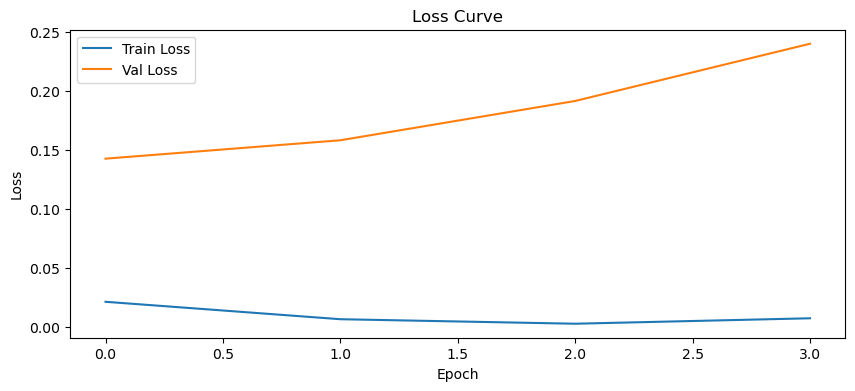

In [19]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

## 9. Model Evaluation on Test Set

In this section, we evaluate the performance of the trained MLP model on the test dataset. 
The model's predictions are generated using a threshold of 0.45, and the results are summarized with a classification report and a confusion matrix. 
This provides a comprehensive overview of the model's generalization ability and its effectiveness in distinguishing between phishing and safe emails.

---

## 9. 테스트 데이터셋에서 모델 평가

이 섹션에서는 학습된 MLP 모델을 테스트 데이터셋에서 평가합니다.
모델의 예측값은 0.45의 임계값(threshold)을 사용하여 생성되며, 분류 리포트와 혼동 행렬(confusion matrix)을 통해 결과를 요약합니다.
이를 통해 모델이 피싱 이메일과 정상 이메일을 얼마나 잘 구분하는지, 그리고 실제 데이터에 대한 일반화 성능을 종합적으로 확인할 수 있습니다.



[MLP] Test Results (threshold=0.45)

Accuracy : 0.9618015963511972
F1 Score : 0.9696969696969697

Classification Report:
               precision    recall  f1-score   support

    phishing       0.96      0.94      0.95      1312
        safe       0.96      0.98      0.97      2196

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



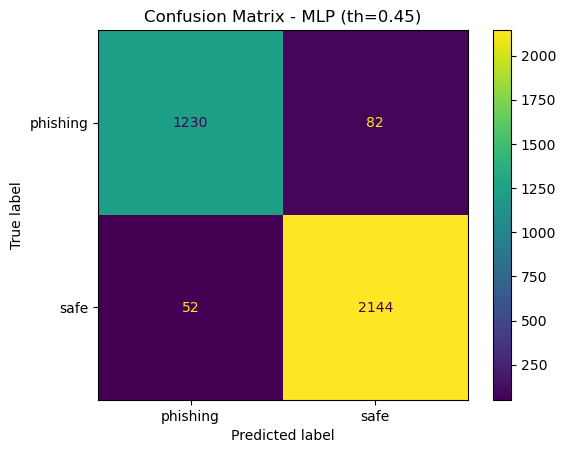

In [ ]:
model = torch.load('mlp_best.pt')
model.eval()  

with torch.no_grad():
    test_output = model(x_test_tensor)
    test_pred = (test_output > 0.45).int()

print("\n[MLP] Test Results (threshold=0.45)\n")
print("Accuracy :", accuracy_score(y_test_tensor, test_pred))
print("F1 Score :", f1_score(y_test_tensor, test_pred))
print("\nClassification Report:\n", classification_report(y_test_tensor, test_pred, target_names=["phishing", "safe"]))

cm = confusion_matrix(y_test_tensor, test_pred)
ConfusionMatrixDisplay(cm, display_labels=["phishing", "safe"]).plot()
plt.title("Confusion Matrix - MLP (th=0.45)")
plt.show()
